<a href="https://colab.research.google.com/github/SindhuVarier/ttm/blob/main/predict_fog_ttm2_zero_shot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fog Prediction

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

The recipe provided in https://github.com/ibm-granite-community/granite-timeseries-cookbook/blob/main/recipes/Time_Series/Preprocessor_Use_and_Performance_Evaluation.ipynb is customized to predict fog for Bengaluru KIA airport.

## Setting Up

### Install the TSFM Library

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here the pinned version is retrieved and installed.

In [ ]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.12" -U
#! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.14"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.12) to /tmp/pip-install-psroc3le/tsfm-public_921c9f3125b94972b1c7a2a1e8e6cfb4
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-psroc3le/tsfm-public_921c9f3125b94972b1c7a2a1e8e6cfb4
  Running command git checkout -q 9484de7a81e9d202ca024ee7924b83a796661dca
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 9484de7a81e9d202ca024ee7924b83a796661dca
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, preprocessor, forecasting pipeline, and plotting function.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
)
from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits
from tsfm_public.toolkit.visualization import plot_predictions

### Specify configuration variables

We provide the names of the timestamp column and the target column to be predicted. The context length and predition length (in time steps) is set to match the pretrained model.

In [ ]:
timestamp_column = "Time"
target_columns = ["visibility_meters"]

context_length = 1536
prediction_length = 96

## Preparing the Data

In [ ]:
DATA_FILE_PATH = "VIDP_cleaned1.csv"

### Read in the data

We parse the CSV into a pandas dataframe. In subsequent steps we will split the input dataframe.

In [ ]:
# Read in the data from the downloaded file.
input_df = pd.read_csv(DATA_FILE_PATH, parse_dates=[timestamp_column])

# Show the last few rows of the dataset.
input_df.tail()

,Time,temperature,dew_point,relative_humidity,wind_direction,wind_speed,pressure_altimeter,visibility_meters,solar_radiation,fog_category
26251,2024-02-29 21:30:00,13.0,11.0,87.65,260.0,4.0,1013.89,2204.8,0.0,NSR
26252,2024-02-29 22:00:00,13.0,11.0,87.65,260.0,4.0,1013.89,2204.8,0.0,NSR
26253,2024-02-29 22:30:00,13.0,11.0,87.65,260.0,4.0,1013.89,2204.8,0.0,NSR
26254,2024-02-29 23:00:00,13.0,11.0,87.65,260.0,4.0,1013.89,2204.8,0.0,NSR
26255,2024-02-29 23:30:00,13.0,11.0,87.65,260.0,4.0,1013.89,2204.8,0.0,NSR


### Plot a segment of the target series

Here we inspect a preview of the target time series.

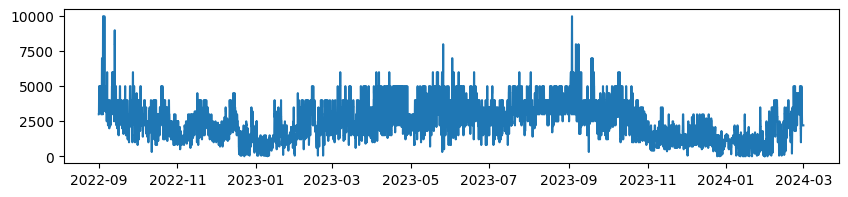

In [ ]:
fig, axs = plt.subplots(len(target_columns), 1, figsize=(10, 2 * len(target_columns)), squeeze=False)
for ax, target_column in zip(axs, target_columns):
    ax[0].plot(input_df[timestamp_column], input_df[target_column])

## Preprocessing the Data

### Split the data into training, validation, and testing sets

We split the data into training, validation, and test sets. The training set is used to train the preprocessor, while the test set is used to evaluate the model performance.

In [ ]:
split_config = {"train": 0.7, "test": 0.2}

train_df, valid_df, test_df = prepare_data_splits(input_df, context_length=context_length, split_config=split_config)
print(f"Data lengths: train = {len(train_df)}, val = {len(valid_df)}, test = {len(test_df)}")

Data lengths: train = 18379, val = 4162, test = 6787


### Train the Preprocessor

The preprocessor is trained on the training portion of the input data to learn the scaling factors. The scaling will be applied when we use the preprocess method of the time series preprocessor.

In [ ]:
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": [],
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=prediction_length,
    scaling=True,
    scaler_type="standard",
)

trained_tsp = tsp.train(train_df)

## Evaluating the Model

### Set up zero shot model
The pretrained TTM model is hosted on [HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1), and is loaded into a `TinyTimeMixerForPrediction` model. We have one input channel in this example.

In [ ]:
# Instantiate the model.
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",  # Name of the model on HuggingFace.
    num_input_channels=len(target_columns),  # Number of input columns.
)

### Run the model

Run the model using a forecasting pipeline, on preprocessed test data.

In [ ]:
# Create a pipeline.
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    device="cpu",  # Specify your local GPU or CPU.
    feature_extractor=tsp,
)

# Make a forecast on the target column given the input data.
zeroshot_forecast = pipeline(test_df)
zeroshot_forecast.head()

,Time,visibility_meters_prediction,visibility_meters
0,2023-10-22 06:00:00,"[2150.3691627601283, 2624.7647381835486, 2975....","[1593.2499566572662, 2092.1400230071026, 2204...."
1,2023-10-22 06:30:00,"[2239.2032250398593, 2647.398347879064, 2930.6...","[2092.1400230071026, 2204.799969969753, 2494.4..."
2,2023-10-22 07:00:00,"[2656.166513816086, 2944.3795374426313, 3149.9...","[2204.799969969753, 2494.4799954030227, 2494.4..."
3,2023-10-22 07:30:00,"[2720.461826449669, 2946.16207432013, 3129.447...","[2494.4799954030227, 2494.4799954030227, 2494...."
4,2023-10-22 08:00:00,"[2916.5527768367474, 3110.1404169454668, 3242....","[2494.4799954030227, 2494.4799954030227, 2494...."


### Evaluate the Model

Evaluate the model on the test dataset using a custom metric. In this case we define three standard metrics, mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE).

In [ ]:
def custom_metric(actual, prediction, column_header="results"):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    p = np.asarray(prediction.tolist())

    mask = ~np.any(np.isnan(a), axis=1)

    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    mae = np.mean(np.abs(a[mask, :] - p[mask, :]))
    return pd.DataFrame(
        {
            column_header: {
                "mean_squared_error": mse,
                "root_mean_squared_error": np.sqrt(mse),
                "mean_absolute_error": mae,
            }
        }
    )


custom_metric(
    zeroshot_forecast["visibility_meters"], zeroshot_forecast["visibility_meters_prediction"], "zero-shot forecast"
)

,zero-shot forecast
mean_squared_error,392335.252527
root_mean_squared_error,626.366708
mean_absolute_error,473.147187


In [ ]:
def custom_r2_score(actual, prediction, column_header="results"):
    """Function to compute R² Score"""
    a = np.asarray(actual.tolist())
    p = np.asarray(prediction.tolist())

    # Create a mask to handle missing values (if any)
    mask = ~np.any(np.isnan(a), axis=1)

    # Calculate metrics
    ss_total = np.sum(np.square(a[mask, :] - np.mean(a[mask, :])))
    ss_residual = np.sum(np.square(a[mask, :] - p[mask, :]))
    r2 = 1 - (ss_residual / ss_total)

    return pd.DataFrame(
        {
            column_header: {
                "r_squared": r2,
            }
        }
    )

# Example usage:
custom_r2_score(
    zeroshot_forecast["visibility_meters"],
    zeroshot_forecast["visibility_meters_prediction"],
    "zero-shot forecast"
)


,zero-shot forecast
r_squared,0.580795


### Plot the Predictions vs. Actuals

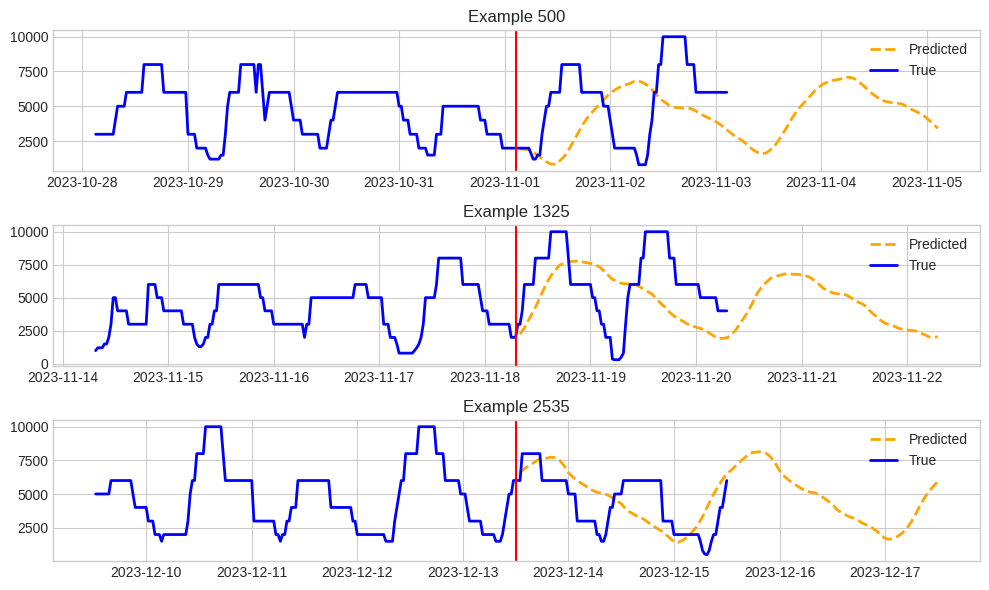

In [ ]:
# plot
plot_predictions(
    input_df=test_df,
    predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_column,
    indices=[500, 1325, 2535],
)

## Making the Forecast

### Use the pipeline to make a forecast

Use the forecasting pipeline we assembled above to make a forward prediction from the end of the original dataset.

In [ ]:
historical = input_df.iloc[-context_length:].copy()

# Make a forecast on the target column given the input data.
zeroshot_forecast = pipeline(historical)
zeroshot_forecast.head()

,Time,visibility_meters_prediction,visibility_meters
0,2024-02-29 05:00:00,"[5660.059903885711, 5393.860553654167, 5087.67...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


### Plot predictions along with the historical data.

The predicted series picks up where the historical data ends, and we can see that it predicts a continuation of the cyclical pattern and an upward trend.

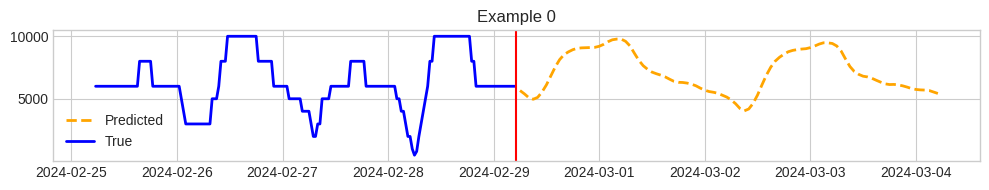

In [ ]:
# Pre-cast the timestamp to avoid dtype inference warnings
historical[timestamp_column] = pd.to_datetime(historical[timestamp_column])

# Plot the historical data and predicted series
plot_predictions(
    input_df=historical,
    predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_column,
    indices=[0],
)

## Links
* Library: [Granite TSFM on Github](https://github.com/ibm-granite/granite-tsfm)
* Model: [TinyTimeMixer on HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1)
* Dataset: